<a href="https://colab.research.google.com/github/OIBSIP-25-26/L2P7/blob/main/L2P7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3945
           1       0.03      0.07      0.05        55

    accuracy                           0.96      4000
   macro avg       0.51      0.52      0.51      4000
weighted avg       0.97      0.96      0.97      4000

ROC AUC: 0.5089249913584515


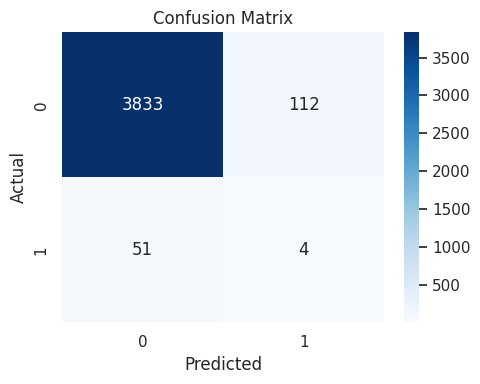

Outputs saved to fraud_output


In [1]:
"""
fraud_detection.py
Detect fraudulent transactions using a simple RandomForest on synthetic data.
Run: python fraud_detection.py
Generates: model saved, classification report printed.
"""
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

OUT_DIR = "fraud_output"
os.makedirs(OUT_DIR, exist_ok=True)
np.random.seed(123)

# Create synthetic transactions
n = 20000
amount = np.random.exponential(scale=100, size=n)  # transaction amount
time_delta = np.random.randint(0, 60*60*24, size=n)  # seconds since some period start
merchant_type = np.random.choice(["grocery","electronics","travel","fashion","utilities"], size=n, p=[0.4,0.15,0.1,0.2,0.15])
customer_age = np.random.randint(18, 75, size=n)
country = np.random.choice(["IN","US","UK","DE","FR"], size=n, p=[0.5,0.2,0.1,0.1,0.1])

# Simulate fraud: small proportion, but correlated with high amount, travel merchant, and odd hours
is_fraud = (np.random.rand(n) < 0.01).astype(int)  # base 1% fraud
is_fraud = np.where((amount>1000) & (np.random.rand(n) < 0.05), 1, is_fraud)
is_fraud = np.where((merchant_type=="travel") & (np.random.rand(n) < 0.03), 1, is_fraud)
is_fraud = np.where(((time_delta%86400) < 3600) & (np.random.rand(n) < 0.02), 1, is_fraud)

df = pd.DataFrame({
    "amount": amount,
    "time_delta": time_delta,
    "merchant_type": merchant_type,
    "customer_age": customer_age,
    "country": country,
    "is_fraud": is_fraud
})

# One-hot encode categorical
df_enc = pd.get_dummies(df, columns=["merchant_type","country"], drop_first=True)

X = df_enc.drop(columns=["is_fraud"])
y = df_enc["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clf = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("Classification report:")
print(classification_report(y_test, y_pred))
try:
    auc = roc_auc_score(y_test, y_proba)
    print("ROC AUC:", auc)
except Exception as e:
    print("ROC AUC not computable:", e)

# Save model
joblib.dump(clf, os.path.join(OUT_DIR, "fraud_rf_model.joblib"))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "confusion_matrix.png"))
plt.show()

df.to_csv(os.path.join(OUT_DIR, "transactions_synthetic.csv"), index=False)
print(f"Outputs saved to {OUT_DIR}")
